### Imports

In [1]:
from keras.datasets import mnist # Only for dataset
import time # note how lon code cells run
import math # to check for nan values

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)

### Get Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


label 5


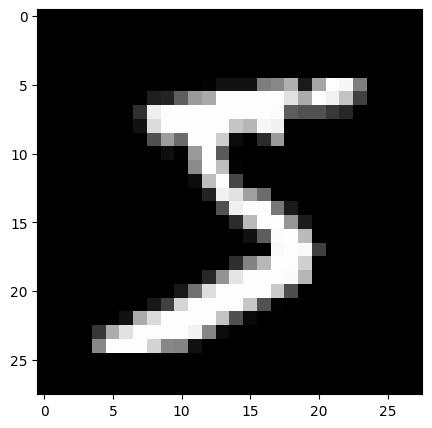

In [3]:
# Visualize 1 sample
print ('label', y_train[0])
plt.imshow(x_train[0], cmap='gray')

### Vectorize the dataset into n,784 and Normalize them (2 points)

In [4]:
# convert 28x28 images to vector of length 784
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Normalize the dataset
# add a small amount at the end of std in case it is 0 and throws divide be zero error
x_train = (x_train - np.mean(x_train, axis=1, keepdims=True)) / (np.std(x_train, axis=1, keepdims=True) + 1e-8)
x_test = (x_test - np.mean(x_test, axis=1, keepdims=True)) / (np.std(x_test, axis=1, keepdims=True) + 1e-8)

# create train output vector
y_train = np.where(y_train > 4, 1, 0)
y_test = np.where(y_test > 4, 1, 0)

print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [5]:
# Stack 1s on train set
x_train = np.hstack((x_train, np.ones((x_train.shape[0], 1))))

# Stack 1s on test set
x_test = np.hstack((x_test, np.ones((x_test.shape[0], 1))))

print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 785) (60000,) (10000, 785) (10000,)


### Linear Classifier (2 Points)

In [6]:
# Utility functions

# function to convert y output vector of size n,1 to onhot vector of size n,(num_unique_vals)
def convert_to_one_hot(labels):
    unique = np.unique(labels)
    onehot = np.zeros((labels.shape[0], unique.shape[0]))
    onehot[np.arange(labels.shape[0]), labels] = 1
    return onehot

# get accuracy
def accuracy(y_true, y_out_oh):
    return np.sum(np.argmax(y_out_oh, axis=1) == y_true)/y_true.shape[0]

# predict labels
def predict(X, w):
    return np.matmul(X, w.T)

# calculate MSE loss
def loss(y_pred_oh, y_true_oh):
    return np.sum(0.5*(y_pred_oh - y_true_oh)**2)/y_pred_oh.shape[0]

# Plot loss given loss array
def plot_loss(loss_array):
    plt.figure(1)
    plt.plot(np.arange(0,len(loss_array)), loss_array)
    plt.title('Train Loss vs iters')
    plt.xlabel('iters')
    plt.ylabel('loss')
    plt.grid()
    plt.show()

# plot train and test accuracy given respective arrays
def plot_accuracy(train_accuracy, test_accuracy):
    plt.figure(2)
    plt.plot(np.arange(0,len(train_accuracy)), train_accuracy, label='train')
    plt.plot(np.arange(0,len(test_accuracy)), test_accuracy, label='test')
    plt.title('Accuracy vs iters')
    plt.xlabel('iters')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

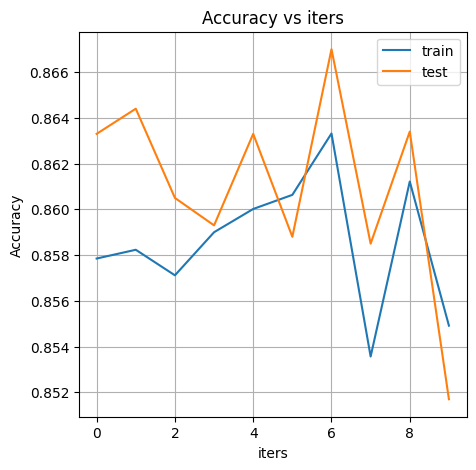

In [7]:
def linear_model(x_train, y_train_true, y_train_oh, x_test, y_test_true, y_test_oh, lr = 0.001, n_epochs=10, batch_size=10):

    # create weights and bias matrix
    # weights has a shape of 2, 785

    input_dim = x_train.shape[1]
    output_dim = y_train_oh.shape[1]

    # weights and biases have been initialized as 0
    w = np.zeros((output_dim, input_dim))

    # store train loss, train accuracy and test accuracy
    loss_array = []
    train_accuracy_array = []
    test_accuracy_array = []

    for epoch in range(n_epochs):

        shuffled_indices = np.random.permutation(x_train.shape[0])
        x_shuffled = x_train[shuffled_indices]
        y_shuffled_oh = y_train_oh[shuffled_indices]

        i = 0
        # Mini-batch SGD
        while i < x_train.shape[0]:
            
            x = x_shuffled[i:i+batch_size]
            y = y_shuffled_oh[i:i+batch_size]

            # Forward pass
            out = predict(x, w)

            # calculate loss mse loss
            # loss = 1/2 * (ypred_oh - ytrue_oh)**2 / N
            l = loss(out, y)

            # Backward Pass
            # calculate gradients for weights and bias
            # dl/dw = ((ypred_oh - ytrue_oh).T).X / N
            w_grad = np.matmul((out - y).T, x) / out.shape[0]

            # optimization
            # update gradients
            w -= lr*w_grad

            i+= batch_size

        # Store Statistics
        loss_array.append(l)

        # train accuracy in entire dataset
        out_train = predict(x_train, w)
        train_acc = accuracy(y_train_true, out_train)
        train_accuracy_array.append(train_acc)

        # test accuracy in entire dataset
        out_test = predict(x_test, w)
        test_acc = accuracy(y_test_true, out_test)
        test_accuracy_array.append(test_acc)

        if (epoch+1) % 20 == 0:
            print ('epoch = {}, train_loss = {}, train_acc = {}, test_acc = {}'.format(epoch+1, l, train_acc, test_acc))

        # if loss is not defined due to poor lr selection, break the loop
        if l == np.inf or math.isnan(l):
            print ('--- loss explodes ---')
            break
    
        
    return w, loss_array, train_accuracy_array, test_accuracy_array

# convert y to one hot encoded
y_train_oh = convert_to_one_hot(y_train)
y_test_oh = convert_to_one_hot(y_test)


w,loss_arr,train_acc, test_acc = linear_model(x_train, y_train, y_train_oh,x_test, y_test, y_test_oh)
plot_accuracy(train_acc, test_acc)

In [8]:
print ("The test accuracy is {}".format(test_acc[-1]))

The test accuracy is 0.8517


### Neural Network (7 Points)

In [9]:
# Utility functions

# quadratic loss
def quadratic_loss(y_true, y_pred):
    # y_true is n, and y_pred is 1,n
    # reshape y_true to 1,n
    return np.mean((y_pred - y_true)**2)

# Calculate sigmoid of single number or np array.
# Required for logistic loss
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# logistic loss
def logistic_loss(y_true, y_pred):
    cumulative_l = 0
    y_pred = y_pred.reshape(-1,)
    for y,y_hat in zip (y_true, y_pred):
        sigmoid_y_hat = sigmoid(y_hat)
        l = (y*np.log(sigmoid_y_hat)) + ((1-y)*np.log(1-sigmoid_y_hat))
        l = -l
        cumulative_l += l
    return cumulative_l/y_true.shape[0]

# calculate the relu activation funtion for the layer
# if derivative of the layer is required, pass in the true flag
def relu(input, derivative = False):
    if derivative:
        return np.where(input > 0, 1, 0)
    else:
        return np.maximum(input, 0)

# calculate accuracy of the model
def get_accuracy(y_true, y_pred):
    y_pred = y_pred.reshape(-1,)

    # label is predicted by hard thresholding
    y_pred = np.where(y_pred > 0.5, 1, 0)

    return np.sum(y_true == y_pred)/y_true.shape[0]

In [10]:
def shallow_neural(x_train, x_test, y_train, y_test, lr=0.01, k=5, epochs=10, batch_size=10, loss_type='quadratic'):

    if loss_type not in ['sigmoid', 'quadratic']:
        raise Exception('Enter Valid loss function')

    np.random.seed(112233)
    # Generate weights from gaussian distribution with 0 mean and 1/d std.
    # Size of weights is k{5,40,200}, d(785(784+bias))
    w = np.random.randn(k, x_train.shape[1]) /x_train.shape[1]
    # Generate weights from gaussian distribution with 0 mean and 1/k std.
    # Size of weights is k{5,40,200}, 1
    v = np.random.randn(k) / k

    train_acc_per_iteration = []
    test_acc_per_iteration = []

    iter_ctr = 0
    for epoch in range(epochs):

        # shuffle the dataset
        shuffled_indices = np.random.permutation(x_train.shape[0])
        x_shuffled = x_train[shuffled_indices]
        y_shuffled = y_train[shuffled_indices]
        
        # Mini-batch SGD
        i = 0
        
        t_before = time.time()
        while i < x_train.shape[0]:
            
            x = x_shuffled[i:i+batch_size]
            y = y_shuffled[i:i+batch_size]

            # FORWARD

            # n is 10 for batch size
            # x is n,d and w is k, d 
            # z1 is n, k
            z1 = np.matmul(x, w.T) 

            # Relu Layer
            # y1 is n, k
            y1 = relu(z1)

            # y1 is n, k and v is k,
            # z2 is n, 
            z2 = np.matmul(y1, v)

            # no activation is required for final output so
            # y2 is n, 
            y2 = z2

            # BACKWARD
            # delta_2 = (Grad of loss w.r.t y2) times (element wise product with first order derivative of activation function)
            # shape of delta_2 is n, 
            if loss_type == 'quadratic':
                delta_2 = 2*(y2 - y)
            else:
                # add a small value in case denominator is 0
                # delta_2 = (y2 - y) / ((y2 * (1 - y2)) + 1e-16)
                delta_2 = (y2 - y)

            # gradient of weights(v) = y1 dot delta_2
            # y1 is n,k is delta_2 is n, 
            # dv is k, 
            dv = np.matmul(y1.T, delta_2) / x.shape[0]

            # shape of z1 is n, k
            # shape of relu_derivative is n, k
            relu_derivative = relu(z1, derivative=True)

            # delta_1 is gradient of loss w.r.t hidden layer 1
            # delta_2 is n, and shape of v is k, 
            # shape of delta_1 is n,k
            delta_1 = np.matmul(delta_2.reshape(-1,1), v.reshape(-1,1).T) * relu_derivative

            # gradients of weight(w)  = x dot delta_1
            # shape of delta_1 is n,k
            # shape of x is n,d
            # shape of dw is d,k
            dw = np.matmul(delta_1.T, x) / x.shape[0]

            # Optimization
            w -= lr*dw
            v -= lr*dv

            i += batch_size

            if iter_ctr == 0 or iter_ctr % 100 == 0:
                # ------------- PER ITERATION ACCURACY ------------ 
                # Train test loss and accuracy
                # Train
                # FORWARD
                z1 = np.matmul(x_train, w.T) 
                y1 = relu(z1)
                z2 = np.matmul(y1, v)
                y2_train = z2

                # Accuracy
                train_accuracy = get_accuracy(y_train, y2_train)
                # Test
                # FORWARD
                z1 = np.matmul(x_test, w.T) 
                y1 = relu(z1)
                z2 = np.matmul(y1, v)
                y2_test = z2
                # Accuracy
                test_accuracy = get_accuracy(y_test, y2_test)

                train_acc_per_iteration.append((iter_ctr, train_accuracy))
                test_acc_per_iteration.append((iter_ctr, test_accuracy))

                # ------------- PER ITERATION LOSS ------------ 

                if loss_type == 'sigmoid':
                    train_l = logistic_loss(y_train, y2_train)
                    test_l = logistic_loss(y_test, y2_test)
                else:
                    train_l = quadratic_loss(y_train, y2_train)
                    test_l = quadratic_loss(y_test, y2_test)

            iter_ctr += 1

        t_after = time.time()
        print (f'epoch : {epoch} | total time for epoch : {(t_after - t_before):.4f}')
        print (f'train_accuracy : {train_accuracy:.4f} | test_accuracy: {test_accuracy:.4f}')
        print (f'train_loss : {train_l:.4f} | test_loss: {test_l:.4f}')
        print ()
        
    return train_acc_per_iteration, test_acc_per_iteration

### Quadratic

Running for K = 5 and loss = quadratic

epoch : 0 | total time for epoch : 10.1860
train_accuracy : 0.9108 | test_accuracy: 0.9130
train_loss : 0.0831 | test_loss: 0.0812

epoch : 1 | total time for epoch : 9.5154
train_accuracy : 0.9291 | test_accuracy: 0.9262
train_loss : 0.0717 | test_loss: 0.0723

epoch : 2 | total time for epoch : 8.7766
train_accuracy : 0.9367 | test_accuracy: 0.9321
train_loss : 0.0656 | test_loss: 0.0673

epoch : 3 | total time for epoch : 9.3030
train_accuracy : 0.9399 | test_accuracy: 0.9344
train_loss : 0.0635 | test_loss: 0.0662

epoch : 4 | total time for epoch : 9.4154
train_accuracy : 0.9459 | test_accuracy: 0.9406
train_loss : 0.0598 | test_loss: 0.0628

epoch : 5 | total time for epoch : 9.4730
train_accuracy : 0.9492 | test_accuracy: 0.9435
train_loss : 0.0573 | test_loss: 0.0597

epoch : 6 | total time for epoch : 9.6746
train_accuracy : 0.9455 | test_accuracy: 0.9384
train_loss : 0.0604 | test_loss: 0.0643

epoch : 7 | total time for epoch : 8.8789


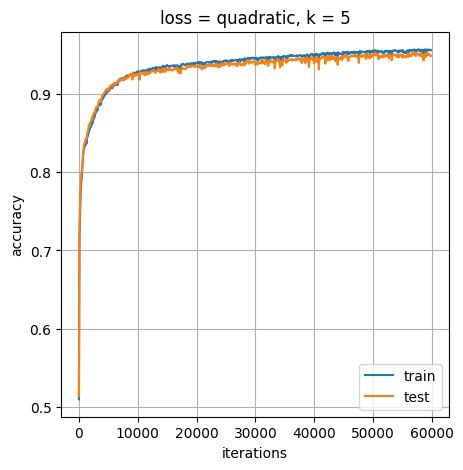

Test Accuracy [0.9484]
 ------------------------- 
Running for K = 40 and loss = quadratic

epoch : 0 | total time for epoch : 14.3499
train_accuracy : 0.8876 | test_accuracy: 0.8917
train_loss : 0.0939 | test_loss: 0.0905

epoch : 1 | total time for epoch : 14.9984
train_accuracy : 0.9411 | test_accuracy: 0.9414
train_loss : 0.0626 | test_loss: 0.0620

epoch : 2 | total time for epoch : 14.7298
train_accuracy : 0.9563 | test_accuracy: 0.9548
train_loss : 0.0500 | test_loss: 0.0511

epoch : 3 | total time for epoch : 14.8726
train_accuracy : 0.9643 | test_accuracy: 0.9637
train_loss : 0.0440 | test_loss: 0.0461

epoch : 4 | total time for epoch : 14.7714
train_accuracy : 0.9694 | test_accuracy: 0.9646
train_loss : 0.0409 | test_loss: 0.0435

epoch : 5 | total time for epoch : 15.1888
train_accuracy : 0.9718 | test_accuracy: 0.9670
train_loss : 0.0373 | test_loss: 0.0406

epoch : 6 | total time for epoch : 14.8853
train_accuracy : 0.9732 | test_accuracy: 0.9683
train_loss : 0.0353 | tes

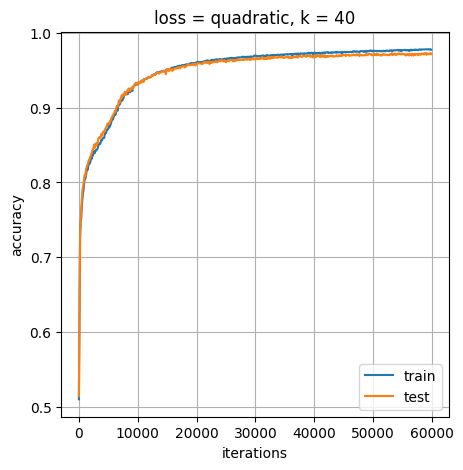

Test Accuracy [0.9715]
 ------------------------- 
Running for K = 200 and loss = quadratic

epoch : 0 | total time for epoch : 46.7608
train_accuracy : 0.8683 | test_accuracy: 0.8728
train_loss : 0.1057 | test_loss: 0.1021

epoch : 1 | total time for epoch : 46.9154
train_accuracy : 0.9448 | test_accuracy: 0.9431
train_loss : 0.0585 | test_loss: 0.0581

epoch : 2 | total time for epoch : 46.9572
train_accuracy : 0.9618 | test_accuracy: 0.9589
train_loss : 0.0455 | test_loss: 0.0466

epoch : 3 | total time for epoch : 46.7146
train_accuracy : 0.9701 | test_accuracy: 0.9666
train_loss : 0.0387 | test_loss: 0.0408

epoch : 4 | total time for epoch : 46.9779
train_accuracy : 0.9744 | test_accuracy: 0.9708
train_loss : 0.0346 | test_loss: 0.0377

epoch : 5 | total time for epoch : 47.6842
train_accuracy : 0.9763 | test_accuracy: 0.9729
train_loss : 0.0318 | test_loss: 0.0350

epoch : 6 | total time for epoch : 48.3977
train_accuracy : 0.9791 | test_accuracy: 0.9744
train_loss : 0.0293 | te

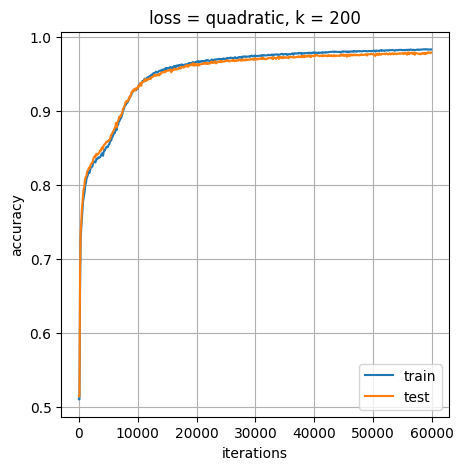

Test Accuracy [0.9785]
 ------------------------- 


In [11]:
accuracy_list = []
loss = 'quadratic'
for k in [5,40,200]:   
    print (f'Running for K = {k} and loss = {loss}')
    print ()
    t0 = time.time()
    train_acc_per_iteration, test_acc_per_iteration = shallow_neural(x_train, x_test, y_train, y_test, lr=0.001, k=k, epochs=10, batch_size=10, loss_type=loss)
    train_acc_per_iteration = np.array(train_acc_per_iteration)
    test_acc_per_iteration = np.array(test_acc_per_iteration)
    t1 = time.time()

    print ()
    print (f'time for K = {k} and loss = {loss} is {(t1 - t0):.4f}')
    plt.figure(1)
    plt.title(f'loss = {loss}, k = {k}')
    plt.plot(train_acc_per_iteration[:, 0], train_acc_per_iteration[:, 1], label='train')
    plt.plot(test_acc_per_iteration[:, 0], test_acc_per_iteration[:,1], label='test')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    print ('Test Accuracy', test_acc_per_iteration[-1:,1])
    accuracy_list.append({'k':k,'test_acc':test_acc_per_iteration[-1:,1][0]*100})
    print (' ------------------------- ')

In [12]:
import pandas as pd

df = pd.DataFrame.from_records(accuracy_list)
df

,k,test_acc
0,5,94.84
1,40,97.15
2,200,97.85


Effect of k on accuracy and optimization

As k increases, the model becomes complex and takes more time for computation. This also means that the model tends to learn more features.
However, this may lead to overfitting which is bad for the model.
On the other hand, if the hidden layer is small, the model may not completely learn all the features.

### Sigmoid

Running for K = 5 and loss = sigmoid

epoch : 0 | total time for epoch : 47.7253
train_accuracy : 0.8779 | test_accuracy: 0.8853
train_loss : 0.6012 | test_loss: 0.6011

epoch : 1 | total time for epoch : 47.6834
train_accuracy : 0.9145 | test_accuracy: 0.9144
train_loss : 0.5793 | test_loss: 0.5792

epoch : 2 | total time for epoch : 47.3958
train_accuracy : 0.9249 | test_accuracy: 0.9226
train_loss : 0.5743 | test_loss: 0.5747

epoch : 3 | total time for epoch : 47.7287
train_accuracy : 0.9294 | test_accuracy: 0.9264
train_loss : 0.5719 | test_loss: 0.5732

epoch : 4 | total time for epoch : 47.3109
train_accuracy : 0.9344 | test_accuracy: 0.9309
train_loss : 0.5647 | test_loss: 0.5659

epoch : 5 | total time for epoch : 47.6547
train_accuracy : 0.9368 | test_accuracy: 0.9324
train_loss : 0.5623 | test_loss: 0.5638

epoch : 6 | total time for epoch : 47.3497
train_accuracy : 0.9357 | test_accuracy: 0.9299
train_loss : 0.5672 | test_loss: 0.5693

epoch : 7 | total time for epoch : 47.

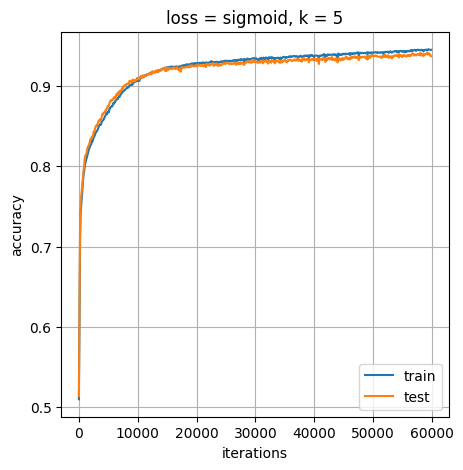

Test Accuracy [0.9369]
 ------------------------- 
Running for K = 40 and loss = sigmoid

epoch : 0 | total time for epoch : 52.3468
train_accuracy : 0.8473 | test_accuracy: 0.8547
train_loss : 0.6090 | test_loss: 0.6087

epoch : 1 | total time for epoch : 53.4078
train_accuracy : 0.8943 | test_accuracy: 0.8981
train_loss : 0.5896 | test_loss: 0.5891

epoch : 2 | total time for epoch : 52.8165
train_accuracy : 0.9281 | test_accuracy: 0.9282
train_loss : 0.5723 | test_loss: 0.5727

epoch : 3 | total time for epoch : 53.0691
train_accuracy : 0.9417 | test_accuracy: 0.9426
train_loss : 0.5633 | test_loss: 0.5640

epoch : 4 | total time for epoch : 53.3850
train_accuracy : 0.9519 | test_accuracy: 0.9518
train_loss : 0.5576 | test_loss: 0.5584

epoch : 5 | total time for epoch : 52.7419
train_accuracy : 0.9584 | test_accuracy: 0.9563
train_loss : 0.5516 | test_loss: 0.5532

epoch : 6 | total time for epoch : 53.5325
train_accuracy : 0.9626 | test_accuracy: 0.9595
train_loss : 0.5509 | test_

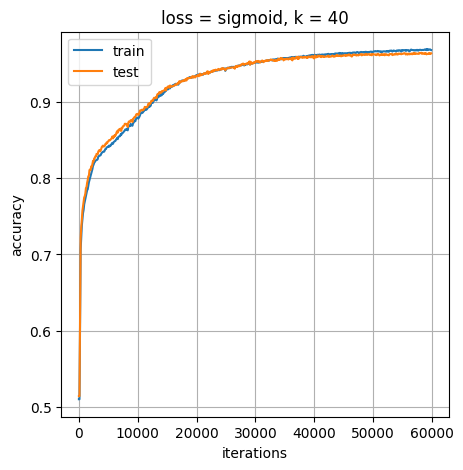

Test Accuracy [0.9638]
 ------------------------- 
Running for K = 200 and loss = sigmoid

epoch : 0 | total time for epoch : 84.5976
train_accuracy : 0.8338 | test_accuracy: 0.8409
train_loss : 0.6185 | test_loss: 0.6185

epoch : 1 | total time for epoch : 84.8738
train_accuracy : 0.8685 | test_accuracy: 0.8741
train_loss : 0.6032 | test_loss: 0.6029

epoch : 2 | total time for epoch : 85.3197
train_accuracy : 0.9231 | test_accuracy: 0.9246
train_loss : 0.5802 | test_loss: 0.5799

epoch : 3 | total time for epoch : 85.3325
train_accuracy : 0.9475 | test_accuracy: 0.9445
train_loss : 0.5634 | test_loss: 0.5633

epoch : 4 | total time for epoch : 84.8288
train_accuracy : 0.9578 | test_accuracy: 0.9538
train_loss : 0.5553 | test_loss: 0.5560

epoch : 5 | total time for epoch : 85.2483
train_accuracy : 0.9626 | test_accuracy: 0.9591
train_loss : 0.5486 | test_loss: 0.5494

epoch : 6 | total time for epoch : 84.9335
train_accuracy : 0.9675 | test_accuracy: 0.9629
train_loss : 0.5474 | test

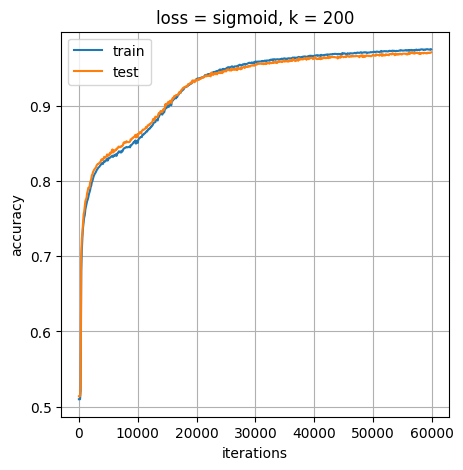

Test Accuracy [0.9707]
 ------------------------- 


In [13]:
accuracy_list = []
loss = 'sigmoid'
for k in [5,40,200]:   
    print (f'Running for K = {k} and loss = {loss}')
    print ()
    t0 = time.time()
    train_acc_per_iteration, test_acc_per_iteration = shallow_neural(x_train, x_test, y_train, y_test, lr=0.001, k=k, epochs=10, batch_size=10, loss_type=loss)
    train_acc_per_iteration = np.array(train_acc_per_iteration)
    test_acc_per_iteration = np.array(test_acc_per_iteration)
    t1 = time.time()

    print ()
    print (f'time for K = {k} and loss = {loss} is {(t1 - t0):.4f}')
    plt.figure(1)
    plt.title(f'loss = {loss}, k = {k}')
    plt.plot(train_acc_per_iteration[:, 0], train_acc_per_iteration[:, 1], label='train')
    plt.plot(test_acc_per_iteration[:, 0], test_acc_per_iteration[:,1], label='test')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    print ('Test Accuracy', test_acc_per_iteration[-1:,1])
    accuracy_list.append({'k':k,'test_acc':test_acc_per_iteration[-1:,1][0]*100})
    print (' ------------------------- ')

In [14]:
import pandas as pd

df = pd.DataFrame.from_records(accuracy_list)
df

,k,test_acc
0,5,93.69
1,40,96.38
2,200,97.07


Effect of k on accuracy and optimization

As k increases, the model becomes complex and takes more time for computation. This also means that the model tends to learn more features. However, this may lead to overfitting which is bad for the model. On the other hand, if the hidden layer is small, the model may not completely learn all the features.

Linear Model and Neural Net

As linear model is simpler in implementation, it has a lower complexity than the neural network. Also, NN with a hidden layer is better able to learn the patterns in the data.

Logistic and Quadratic

In general we can see that logistic loss is better suited for a classification problem such as the one given here. Thus, we can see that the accuracy for classification is better for the logistic model.

In terms of optimization, we can see that logistic loss converges faster than quadratic loss

In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!jupyter nbconvert --log-level CRITICAL --to pdf ./fall2022_hw2.ipynb # make sure the ipynb name is correct